In [3]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import join

from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models
import torch.nn.functional as F

from sklearn import preprocessing

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.__version__

'1.0.0'

In [4]:
np.random.seed(0)

In [10]:
INPUT_SIZE = 224
# NUM_CLASSES = 16
root_dir = '.'
labels = pd.read_csv(join(root_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(root_dir, 'sample_submission.csv'))
print(len(listdir(join(root_dir, 'train'))), len(labels))
print(len(listdir(join(root_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [13]:
sample_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [12]:
# selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
# labels = labels[labels['breed'].isin(selected_breed_list)]
le = preprocessing.LabelEncoder()
labels['class'] = le.fit_transform(labels['breed'])
# labels['target'] = 1
# labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels.sample(frac=0.9)
valid = labels[~labels['id'].isin(train['id'])]
test = pd.DataFrame(sample_submission['id'])
print(len(train), len(valid), len(test))

9200 1022 10357


In [14]:
labels.head()

,id,breed,class
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [57]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, train = True, transform=None):
        self.train = train
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullpath = join(self.root_dir, img_name)
        image = Image.open(fullpath)
        if self.transform:
            image = self.transform(image)
            
        if self.train:
            labels = self.labels.iloc[idx, 2]
            return image, labels
        else:
            ids = self.labels.iloc[idx, 0]
            return image, ids

In [58]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),                           
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    normalize
])

test_trans = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

train_ds = DogsDataset(train, join(root_dir,'train'), train=True, transform=ds_trans)
valid_ds = DogsDataset(valid, join(root_dir,'train'), train=True, transform=ds_trans)
test_ds = DogsDataset(test, join(root_dir,'test'), train=False, transform=test_trans)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [59]:
def imshow(inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp =  inp.clip(min=0,max=1)
    plt.imshow(inp)
    plt.show()

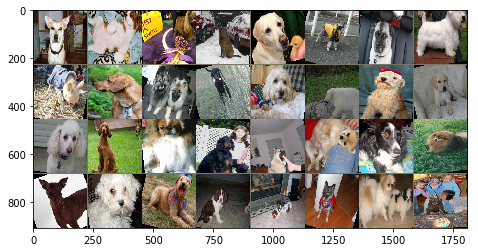

In [60]:
imgs, labels = next(iter(train_dl))

fig = plt.figure(1, figsize=(16, 4))
imshow(torchvision.utils.make_grid(imgs))


In [89]:
# use_gpu = torch.cuda.is_available()
# resnet = models.resnet18(pretrained=True)
# inputs, labels = next(iter(train_dl))

# resnet = resnet.to(device)
# inputs, labels = inputs.to(device), labels.to(device)   

# outputs = resnet(inputs)
# outputs.size()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Will_/.torch\models\resnet18-5c106cde.pth
100.0%


torch.Size([32, 1000])

In [127]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
    
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [128]:
# freeze all model parameters
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 120 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 120)

resnet = resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [129]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/9] train loss: 0.1306 acc: 0.1505 valid loss: 0.1079 acc: 0.3151
Epoch [1/9] train loss: 0.0937 acc: 0.4379 valid loss: 0.0817 acc: 0.4795
Epoch [2/9] train loss: 0.0727 acc: 0.5696 valid loss: 0.0660 acc: 0.5851
Epoch [3/9] train loss: 0.0604 acc: 0.6317 valid loss: 0.0568 acc: 0.6301
Epoch [4/9] train loss: 0.0527 acc: 0.6723 valid loss: 0.0513 acc: 0.6507
Epoch [5/9] train loss: 0.0474 acc: 0.6898 valid loss: 0.0469 acc: 0.6751
Epoch [6/9] train loss: 0.0436 acc: 0.7103 valid loss: 0.0448 acc: 0.6771
Epoch [7/9] train loss: 0.0413 acc: 0.7233 valid loss: 0.0443 acc: 0.6888
Epoch [8/9] train loss: 0.0410 acc: 0.7289 valid loss: 0.0441 acc: 0.6918
Epoch [9/9] train loss: 0.0409 acc: 0.7276 valid loss: 0.0444 acc: 0.6634
Best val Acc: 0.691781
Training time:  11.939763 minutes


In [140]:

res_list = []
ids_list = []
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, ids = data
        images = images.to(device)

        outputs = model(images)

        outputs_softmax = F.softmax(outputs,dim=1)

        res_list.append(outputs_softmax.cpu().numpy())
        ids_list.append(ids)


In [151]:
submission_file = pd.DataFrame(np.concatenate(res_list))
submission_file = pd.concat([sample_submission['id'],submission_file], axis=1)
submission_file.columns = list(sample_submission.columns)
submission_file.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.001964,0.019709,0.002558,0.000452,0.004750,0.000982,0.000834,0.003600,0.034233,...,0.003281,0.003676,0.012938,0.004253,0.059657,0.003794,0.005377,0.026961,0.002186,0.001541
1,00102ee9d8eb90812350685311fe5890,0.000313,0.000383,0.000329,0.000193,0.000900,0.000789,0.001115,0.002939,0.000594,...,0.001984,0.003895,0.000300,0.001173,0.000574,0.000346,0.004782,0.001091,0.001038,0.000473
2,0012a730dfa437f5f3613fb75efcd4ce,0.000864,0.010084,0.001204,0.001635,0.036507,0.000748,0.000506,0.004939,0.005894,...,0.005619,0.002728,0.013588,0.009407,0.038132,0.004794,0.007104,0.060634,0.004355,0.001465
3,001510bc8570bbeee98c8d80c8a95ec1,0.002661,0.009081,0.005283,0.003216,0.012437,0.006316,0.000946,0.013693,0.010209,...,0.011067,0.003274,0.012628,0.002214,0.037326,0.002619,0.002426,0.043159,0.005641,0.005392
4,001a5f3114548acdefa3d4da05474c2e,0.019920,0.015412,0.001625,0.001285,0.004784,0.003383,0.012139,0.001833,0.003409,...,0.012816,0.004013,0.002580,0.003970,0.001588,0.005663,0.041624,0.001141,0.009614,0.039952


In [237]:
submission_file.to_csv('./submission_file_resnet.csv', index=False)